In [68]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import numpy
#from fastkml import kml
from bs4 import BeautifulSoup
from PIL import Image
import matplotlib.image as mpimg
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [69]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [70]:
#Im going to create a function. The input of the function is a raster file with dimentions (n pixels,m pixels), 
#and the output is going to be an array of dimmensions (m*n,1). That means, that each pixel is going to have a unique identifier 
#(index in the array). This index follows the formula (i*n)+j where (i,j) is the position of the pixel in the image and n is the 
#width of the image.

def feature_to_array(file_n):
    im = mpimg.imread(file_n)  
    im_greyscale = rgb2gray(im)   
    imarray = numpy.array(im_greyscale)
    feature=[i for a in imarray for i in a]
    return feature

In [71]:
file_name='Raster_images/BusStop.png'
im = mpimg.imread(file_name)  
im_greyscale = rgb2gray(im)  

In [72]:
file_name='Raster_images/BusStop.png'
array1=feature_to_array(file_name)
len(array1)

935000

In [73]:
#LABEL
file_name='Raster_images/Case.png'
array2=feature_to_array(file_name)
len(array2)

935000

In [74]:
#IN OR OUT SINGAPOURE
file_name='Raster_images/Land.png'
array3=feature_to_array(file_name)
len(array3)

935000

In [75]:
file_name='Raster_images/Mosquito.png'
array4=feature_to_array(file_name)
len(array4)

935000

In [76]:
file_name='Raster_images/Str_Density.png'
array5=feature_to_array(file_name)
len(array5)

935000

In [77]:
file_name='Raster_images/Trash.png'
array6=feature_to_array(file_name)
len(array6)

935000

In [145]:
array22=list(array2/np.max(array2))
inorout33=list(1-(array3/np.max(array3)))

In [146]:
Data=pd.DataFrame([array1,array22,array4,array5,array6]).T

In [179]:
Data.head()

,0,1,2,3,4
0,0.941176,1,0.941176,0.941176,0.941176
1,0.941176,1,0.941176,0.941176,0.941176
2,0.941176,1,0.941176,0.941176,0.941176
3,0.941176,1,0.941176,0.941176,0.941176
4,0.941176,1,0.941176,0.941176,0.941176


In [156]:
Data_filt=Data[np.array(inorout33)==1.0]

In [157]:
Data_filt.head()

,0,1,2,3,4
147867,0.941176,1,0.941176,0.941176,0.941176
150112,0.941176,1,0.941176,0.941176,0.941176
150113,0.941176,1,0.941176,0.941176,0.941176
150114,0.941176,1,0.941176,0.941176,0.941176
151167,0.219608,1,0.941176,0.121569,0.000000


In [118]:
#Outuput: dictionary linking index of one dimmensional array and original i,j position of pixel:
m=numpy.array(Image.open(file_name)).shape[0]
n=numpy.array(Image.open(file_name)).shape[1]
def indexes(m,n):    
    index_2dim={}
    for M in range(0,m*n):
        index_2dim[M]={'i':int(M)/int(n), 'j':M-((int(M)/int(n))*n)}
    return index_2dim

In [119]:
original_index_dict=indexes(m,n)

In [120]:
original_index_dict[386]

{'i': 0, 'j': 386L}

###MACHINE LEARNING PART

In [158]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import KFold
import itertools

In [159]:
pca = PCA()
forest = RandomForestClassifier()
pipe = Pipeline(steps=[('pca', pca), ('forest', forest)])

In [166]:
X = Data_filt[[0,2,3,4]]
Y = Data_filt[1]

In [167]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=21)
Y_train, Y_test = train_test_split(Y, test_size=0.2, random_state=21)

In [168]:
pca.fit(X_train.as_matrix())

PCA(copy=True, n_components=None, whiten=False)

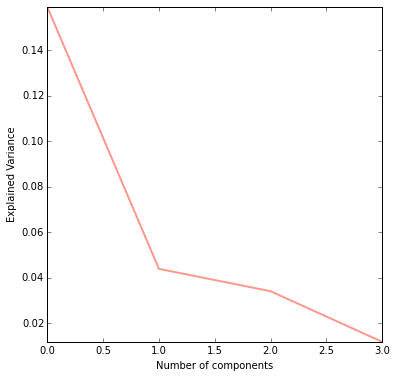

In [169]:
plt.figure(1, figsize=(6, 6))
plt.plot(pca.explained_variance_, linewidth=2, c='salmon', alpha=0.8)
plt.axis('tight')
plt.xlabel('Number of components');
plt.ylabel('Explained Variance');

In [172]:

#check parameters for GridSearchCV using estimator.get_params().keys()
n_components = [1,2,3,4]
max_features = ['auto','sqrt','log2']
criterion = ['gini','entropy']
n_estimators = [3,6,9]
estimator = GridSearchCV(pipe,dict(pca__n_components=n_components,
                    forest__n_estimators=n_estimators, forest__criterion=criterion,
                    forest__max_features=max_features),iid=True,cv=5,refit=True)

In [173]:
estimator.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('pca', PCA(copy=True, n_components=None, whiten=False)), ('forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'forest__max_features': ['auto', 'sqrt', 'log2'], 'pca__n_components': [1, 2, 3, 4], 'forest__n_estimators': [3, 6, 9], 'forest__criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [174]:
print estimator.best_estimator_
print estimator.best_params_

Pipeline(steps=[('pca', PCA(copy=True, n_components=4, whiten=False)), ('forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
{'forest__max_features': 'auto', 'pca__n_components': 4, 'forest__n_estimators': 9, 'forest__criterion': 'entropy'}


In [175]:
estimator.best_score_

0.99033775385193201

In [176]:
pca = PCA(n_components=4)
pca.fit(X_train)
forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False).fit(pca.fit_transform(X_train),Y_train)

In [177]:
forest.feature_importances_


array([ 0.34224841,  0.24011298,  0.2173172 ,  0.20032142])

In [178]:
accuracy_score(Y_test,forest.predict(pca.fit_transform(X_test)))


0.98757019708838578

In [181]:
pred_labels=forest.predict(X)

In [185]:
sum([pred_labels==1])

269368

In [187]:
Data_filt['pred_labels']=pred_labels

C:\Users\Marco\Anaconda\lib\site-packages\IPython\kernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [188]:
Data_filt.head()

,0,1,2,3,4,pred_labels
147867,0.941176,1,0.941176,0.941176,0.941176,1
150112,0.941176,1,0.941176,0.941176,0.941176,1
150113,0.941176,1,0.941176,0.941176,0.941176,1
150114,0.941176,1,0.941176,0.941176,0.941176,1
151167,0.219608,1,0.941176,0.121569,0.000000,1


In [189]:
#0 disease, 1 no disease, 2 outside singapore 
matrix = np.zeros((m,n))

0.0